In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import NoReturn, List

import queue

In [2]:
class Plot:
    legends: List[str] = []
    
    def __init__(self, xlabel: str, ylabel: str, title: str):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
    
    def add(self, x: np.array, y: np.array, legend: str) -> NoReturn:
        assert len(x) == len(y)
        plt.plot(x, y)
        self.legends.append(legend)
    
    def show(self) -> NoReturn:
        plt.legend(self.legends)
        plt.show()


### Первая часть

Пусть n - количество окошек. Очевидно, что среднее время ожидания людей с позицией от 1 до n в очереди равняется нулю. А для людей с позицией больше 2n время ожидания бесконечность, так как не будет окон, готовых их обслуживать

Хотим понять, что-то про промежуток (n, 2n]

#### Постановка

Пусть $ X_1, X_2, \dots, X_n $ - время обслуживания первых n человек их очереди. Тогда заметим, что время ожидания (n + i)-ого человека из очереди будет равнятся $ X_{(i)} $ - i-той порядковой статистике

Тогда модуляция одного эксперимента будет выглядит следующим образом. Мы сгенерируем n случайный величин и отсортируем их

Проведем эксперимент много раз и возьмем выборочное матожидание 

In [3]:
class FirstPartExperiment:
    windows_number: int 
    alpha: float
        
    experiments_number = 1000
    
    def __init__(self, windows_number: int, alpha: float):
        self.windows_number = windows_number
        self.alpha = alpha
    
    def modeling(self) -> np.array:
        return np.sort(np.random.exponential(self.alpha, self.windows_number))
    
    def run(self) -> np.array:
        result = np.zeros(self.windows_number)
        for _ in range(self.experiments_number):
            result += self.modeling()
        return result / self.experiments_number


In [4]:
class FirstPartTask:
    alphas = [0.5, 1, 2]
    windows_numbers = [100, 500]
    
    def run(self) -> NoReturn:
        for windows_number in self.windows_numbers:
            plot = Plot("queue position", "time waiting", f"windows number is {windows_number}")
            x = np.arange(windows_number + 1, 2 * windows_number + 1)
            for alpha in self.alphas:
                experiment = FirstPartExperiment(windows_number, alpha)
                y = experiment.run()
                plot.add(x, y, f"alpha is {alpha}")
            plot.show()


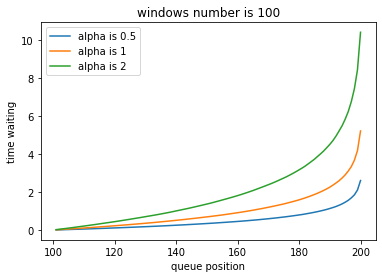

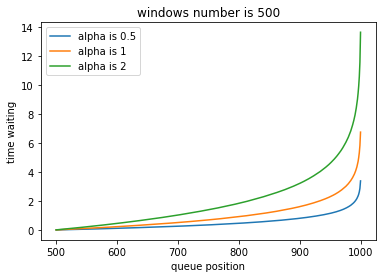

In [5]:
task = FirstPartTask()
task.run()

### Вывод

Как видим, получили экспонинциальную зависимость времени от места в очереди

Вообще, это очевидно 

### Вторая часть 

Пусть n - количество окошек. Тогда замечание про первых n людей из очереди по-прежднему остается верным. Хотим понять про оставшихся

#### Постановка 

Пусть $ A_0 = \{ X_1, X_2, \dots, X_n \} $ - время обслуживания первых n человек их очереди.

Посмотрим на следующие итеративно заданные величины:

$$ T_{k} = \min(A_{k - 1}) $$
$$ A_{k} = (A_{k - 1} / \{ T_{k} \}) \cup \{ T_{k} + X_{n + k} \} $$

Заметим, что $ T_{k} $ время ожидания (n + k)-того человека из очереди. 

Промоделируем данный итеративный процесс, использую очередь с приоритетом, чтобы добиться большей скорости

In [6]:
class SecondPartExperiment:
    windows_number: int 
    queue_size: int
    alpha: float
        
    experiments_number = 1000
    
    def __init__(self, windows_number: int, queue_size: int, alpha: float):
        self.windows_number = windows_number
        self.queue_size = queue_size
        self.alpha = alpha
    
    def modeling(self) -> np.array:
        heap = queue.PriorityQueue()
        for _ in range(self.windows_number):
            heap.put(np.random.exponential(self.alpha))
        result = [0] * self.queue_size
        for i in range(self.queue_size):
            result[i] = heap.get()
            heap.put(result[i] + np.random.exponential(self.alpha))
        return np.array(result)
    
    def run(self) -> np.array:
        result = np.zeros(self.queue_size)
        for _ in range(self.experiments_number):
            result += self.modeling()
        return result / self.experiments_number


In [7]:
class SecondPartTask:
    alphas = [0.5, 1, 2]
    windows_numbers = [100, 500]
    
    def run(self) -> NoReturn:
        for windows_number in self.windows_numbers:
            plot = Plot("queue position", "time waiting", f"windows number is {windows_number}")
            queue_size = 5 * windows_number
            x = np.arange(windows_number + 1, windows_number + queue_size + 1)
            for alpha in self.alphas:
                experiment = SecondPartExperiment(windows_number, queue_size, alpha)
                y = experiment.run()
                plot.add(x, y, f"alpha is {alpha}")
            plot.show()


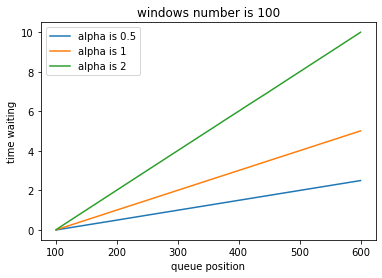

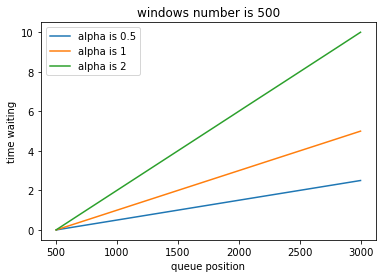

In [8]:
task = SecondPartTask()
task.run()

### Вывод

Получили линейную зависимость времени от позиции в очереди